### Poetry generation

Let's try to generate some poetry using RNNs.


In [ ]:
import string
import os
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output

### Data loading: Shakespeare

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2023-12-14 13:35:18--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-12-14 13:35:18 (7.97 MB/s) - ‘onegin.txt’ saved [262521/262521]



In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

In [ ]:
tokens = sorted(set(text)) + ['<sos>', '<eos>']

Creating dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
token_to_idx = dict(zip(tokens, range(len(tokens))))
idx_to_token = dict(zip(range(len(tokens)), tokens))

In [ ]:
len(token_to_idx)

85

### Building the model

In [ ]:
batch_size = 256
seq_length = 100
text_encoded = [token_to_idx[x] for x in text]
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']
end_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<eos>']
num_tokens = len(token_to_idx)

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data, end_column))

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens = num_tokens, emb_size=38, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        #assert isinstance(x.data, torch.LongTensor)
        h_seq, a = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

model = CharRNNLoop()
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.NLLLoss()
history = []
n_epoch = 1000

In [ ]:
for i in range(1000):
    model.train()
    batch_ix = next(generate_chunk())
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape((-1, num_tokens)), actual_next_tokens.reshape(-1))

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    #<YOUR CODE>

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    model.eval()
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
      a = char_rnn(x_sequence[:, i])

    # your code here
    for _ in range(max_length - len(seed_phrase)):
        logits_next = char_rnn(x_sequence[:, -1])
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        if next_ix == token_to_idx['<eos>']:
          break

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.5))

<sos> мой дядя самых честных правиль,
и,
острата»
ва ни орарыхони ска пелель.
оны
стра задатоспей ска ви ви знодатри грононо ви го

каноскатетать нонизности ны
ой пой ской стевы
тати ноноду праленых ня пре ра х пратой жей пи пой зязастревыхогогой струзя?».
ка,
тря метотвны, ватраль?
остони ода о ви одале поделины
а ви поструча лареной ни ме вевлени,
и ня блетре пра пренодестаноженоста,
оскрадеца и оны,
при страралейдоручи ни оскаталь,
тени ини сте ни лю ме пи пратога сто при задценостечатодетручатра 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [ ]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens = num_tokens, emb_size=38, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, dropout = 0.3, num_layers=2)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        #assert isinstance(x.data, torch.LongTensor)
        h_seq, a = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

model = CharLSTMLoop()
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.NLLLoss()
history = []
n_epoch = 1000

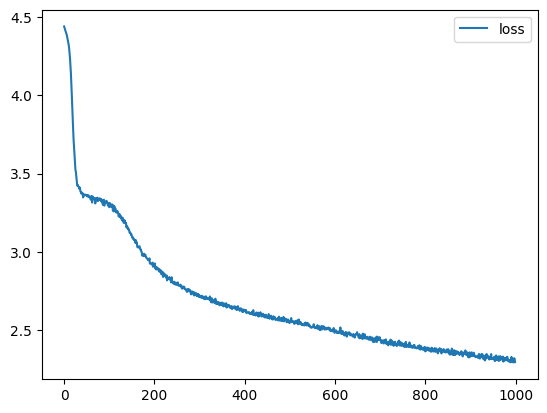

In [ ]:
for i in range(1000):
    batch_ix = next(generate_chunk())
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape((-1, num_tokens)), actual_next_tokens.reshape(-1))

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    #<YOUR CODE>

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
for i, temp in enumerate([0.1, 0.2, 0.5, 1.0, 2.0]):
  print('-------------' + str(i) + '-------------')
  print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=temp))

-------------0-------------
<sos> мой дядя самых честных правилетонодононононодононононононодононо ноно стода стононода стононононононода стонодононононононононононононой нодононононони стононононодонононой стононононононы нононононо нононононола стонононононононой стонононононононо стононода нони стонодононода нони нонодо нононода ни нонононодо нонононо нони нонода стоной нодононодонони нононода нетой нононодононой стонода нононодони нонода нононины ны нононы нононода стононода нода нода ной стой но нода стой нонононононононон
-------------1-------------
<sos> мой дядя самых честных правилоной стой стетода стода нетоной мадето стеноно ни нода ны нодой ноной ной нононодони ной ноны пра нононой нодой стето стоны той нононо нето нононе вонононетой нони нони стодой тода стетой вонотенолонода сто ста стенонона вета сте ста нони не стетода стой вони нони ны ной нони нодода стеноне стоной пра стенодни ноде нонодеру ста стоди но стой стононы веноно стононы нола стоны ной стодонодоны ноноланой